# Showing statistical significance on seaborn plots with Statannotations

## Introduction

Many libraries are available in Python to clean, analyze, and plot data.
Python also has robust statistical packages which are used by thousands of other projects.
On Github only, `statsmodels` is used today in more than 44,000 open-source projects, and `scipy` in more than 350,000 ! (granted, not all for `scipy.stats`).

That said, if you wish, basically, to add p-values to your plots, with the beautiful brackets as you can see in papers using R or other statistical software, there are not many options.


In this tutorial, we will describe `statannotations`, a package to add statistical significance annotations on seaborn categorical plots.


We will first setup the required tools, than describe the dataset we'll work on. Then, we'll learn how to do go from plots like this,
![Adding annotations](./example_hue_layout_no_annot.png)
to plots like this &darr; !
![Adding annotations](./example_hue_layout.png)

**DISCLAIMER**: This tutorial aims to describe *how to use a plot annotation library, not to teach statistics*. The examples are only illustrative for the plots, not the statistical methodology which would have required the careful definition of a research question and maybe, ultimately, different group comparisons and/or tests.

## Preparing the tools
First, let's prepare the tools we'll need, namely `pandas`, `numpy`, `pyplot`, `scipy`, and of course `seaborn`, plus a few additional functions.

##### Imports

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# A few helper functions:
from utils import *


import numpy as np
from scipy.stats import mannwhitneyu, normaltest

In `utils`, the folowing functions are implemented:

Pretty-print:
- `print_n_projects`:
    Prints the number of projects in the passed dataset
- `describe_array`:
    Prints a few statistics about the 1D-array
- `print_projects_by`:
    Prints a list of projects, sorted by `func` result by `Subcategory`

And these, to reduce repetition for plotting:

- `get_log_ax`:
    Creates a new pyplot `ax` and applies a logarithmic scale
- `label_plot_for_subcat`:
    Adds title and axes labels for plots with `Subcategory` as `x` coordinate
- `label_plot_for_state`:
    Adds title and axes labels for plots with `State` as `x` coordinate
- `add_legend`:
    Adds the legend to the plot

## Preparing the data

For this tutorial, I found the kickstarter dataset
"Data for 375,000+ Kickstarter projects from 2009-2017" found on https://www.mavenanalytics.io/data-playground,
including 374,853 campaigns. Let's have a quick peak:

In [4]:
dataset = pd.read_csv('../kickstarter_projects.csv')
dataset.head()

,ID,Name,Category,Subcategory,Country,Launched,Deadline,Goal,Pledged,Backers,State
0,1860890148,Grace Jones Does Not Give A F$#% T-Shirt (limi...,Fashion,Fashion,United States,2009-04-21 21:02:48,2009-05-31,1000,625,30,Failed
1,709707365,CRYSTAL ANTLERS UNTITLED MOVIE,Film & Video,Shorts,United States,2009-04-23 00:07:53,2009-07-20,80000,22,3,Failed
2,1703704063,drawing for dollars,Art,Illustration,United States,2009-04-24 21:52:03,2009-05-03,20,35,3,Successful
3,727286,Offline Wikipedia iPhone app,Technology,Software,United States,2009-04-25 17:36:21,2009-07-14,99,145,25,Successful
4,1622952265,Pantshirts,Fashion,Fashion,United States,2009-04-27 14:10:39,2009-05-26,1900,387,10,Failed


Campaigns are categorized into categories:

In [5]:
list(dataset.Category.unique())

['Fashion',
 'Film & Video',
 'Art',
 'Technology',
 'Journalism',
 'Publishing',
 'Theater',
 'Music',
 'Photography',
 'Games',
 'Design',
 'Food',
 'Crafts',
 'Comics',
 'Dance']

I like technology, let's see what's in there

##### Exploring the Technology category

In [6]:
tech = dataset.loc[(dataset.Category=='Technology'), :]
print_n_projects(tech, 'Technology')

There are 32562 projects in Technology.


Wow ! In what subcategories ?

##### Number of projects by `Subcategory`

In [7]:
# List of tech subcategory, sorted by number of projects
print_projects_by(tech, 'ID', 'count')

1. Technology           6.93e+03
2. Apps                 6.34e+03
3. Web                  3.91e+03
4. Hardware             3.66e+03
5. Software             3.05e+03
6. Gadgets              2.96e+03
7. Wearables            1.23e+03
8. DIY Electronics      9.02e+02
9. 3D Printing          6.82e+02
10. Sound               6.69e+02
11. Robots              5.72e+02
12. Flight              4.26e+02
13. Camera Equipment    4.16e+02
14. Space Exploration   3.23e+02
15. Fabrication Tools   2.50e+02
16. Makerspaces         2.38e+02


The largest subcategory is `Technology` (no further refined), with almost 7,000 registered projects, while the smallest, `Makerspaces` has 238.

Let's now have a look at the `Goal` colum, representing the objectives for financing the projects.

##### Total Goal amounts by `Subcategory`

In [8]:
# List of tech subcategories, sorted by sum of project Goals
print_projects_by(tech, "Goal", "sum")

1. Technology           1.11e+09
2. Apps                 4.49e+08
3. Web                  4.00e+08
4. Hardware             3.43e+08
5. Software             2.85e+08
6. Space Exploration    1.86e+08
7. Gadgets              1.55e+08
8. Robots               1.07e+08
9. Wearables            7.47e+07
10. Flight              5.93e+07
11. 3D Printing         3.18e+07
12. Sound               3.12e+07
13. Makerspaces         3.11e+07
14. Fabrication Tools   2.90e+07
15. DIY Electronics     1.81e+07
16. Camera Equipment    1.66e+07


Looking for potentially intersting data, I see that the order `Sound`, `Robots`, `Flight` (10, 11, 12) is not kept when looking at goal totals (respectively 12, 8, and 10).  `Flight` projects have a larger total amount than `Sound` projects, even as there are fewer of them. `Sound` has the lowest total goal amount, while `Robots` is now at the 8th position.

#### Let's have a closer look to these categories: `Robots`, `Flight`, `Sound` (`rfs`)
I'd like to know more about this apparent difference, don't you ?

In [9]:
rfs = tech.loc[(tech.Subcategory.isin(("Robots", "Flight", "Sound"))), :]

print_n_projects(rfs, "rfs")

There are 1667 projects in rfs.


Let's define colors and orderings for subcategories and states plots

In [10]:
subcat_palette = sns.cubehelix_palette(start=0.2)
state_palette = sns.color_palette("Set2")

states_order = ["Successful", "Failed", "Live", "Suspended", "Canceled"]
subcat_order = ['Robots', 'Flight', 'Sound']

#### PLOT 1

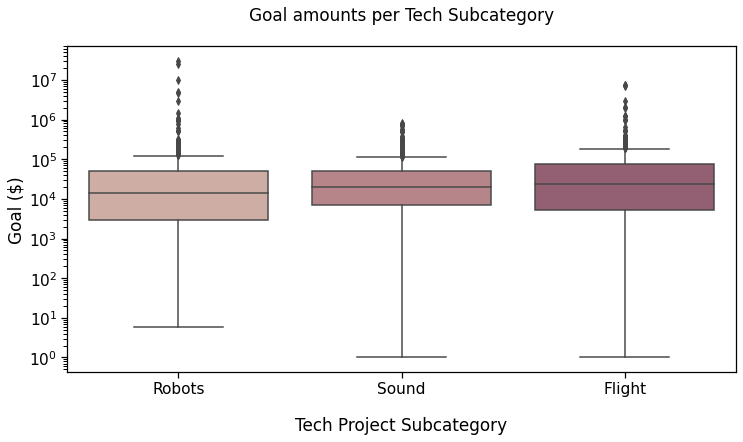

In [11]:
with sns.plotting_context("notebook", font_scale = 1.4):
    # Create new plot
    ax = get_log_ax()

    sns.boxplot(ax=ax, data=rfs, x='Subcategory', y='Goal', palette=subcat_palette[1:])

    label_plot_for_subcat(ax)
    plt.savefig("plot1.png", bbox_inches='tight')

#### PLOT 2

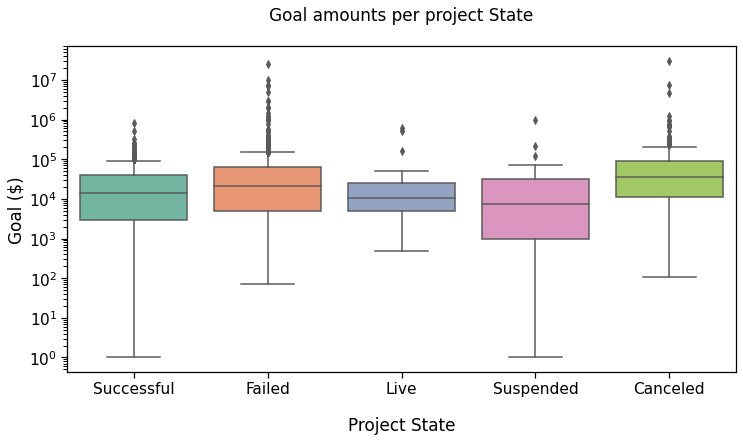

In [12]:
with sns.plotting_context("notebook", font_scale = 1.4):
    # Create new plot
    ax = get_log_ax()

    # Plot with seaborn
    sns.boxplot(ax=ax, data=rfs, x='State', y='Goal', palette=state_palette,
                order=states_order)

    label_plot_for_state(ax)
    plt.savefig("./plot2.png", bbox_inches='tight')


#### So, are these values `statistically` different ?

### Prepare arrays for `scipy`

###### By `Subcategory`

In [13]:
robots = rfs.loc[(rfs.Subcategory == "Robots"), "Goal"].values
flight = rfs.loc[(rfs.Subcategory == "Flight"), "Goal"].values
sound = rfs.loc[(rfs.Subcategory == "Sound"), "Goal"].values

log_robots = np.log(robots)
log_flight = np.log(flight)
log_sound = np.log(sound)

describe_array(robots, "Robots")
describe_array(flight, "Flight")
describe_array(sound, "Sound")
print()
describe_array(log_robots, "Log(Robots)")
describe_array(log_flight, "Log(Flight)")
describe_array(log_sound, "Log(Sound)")

"Robots"       Number of projects: 572	Min: 6.00	Max: 3.00e+07	Avg: 187211.62	Median: 1.43e+04
"Flight"       Number of projects: 426	Min: 1.00	Max: 7.50e+06	Avg: 139219.90	Median: 2.40e+04
"Sound"        Number of projects: 669	Min: 1.00	Max: 8.00e+05	Avg: 46710.19	Median: 2.00e+04

"Log(Robots)"  Number of projects: 572	Min: 1.79	Max: 1.72e+01	Avg: 9.42	Median: 9.57e+00
"Log(Flight)"  Number of projects: 426	Min: 0.00	Max: 1.58e+01	Avg: 9.87	Median: 1.01e+01
"Log(Sound)"   Number of projects: 669	Min: 0.00	Max: 1.36e+01	Avg: 9.79	Median: 9.90e+00


#### Test normality

In [14]:
print("Robots: ", normaltest(robots).pvalue)
print("Flight: ", normaltest(flight).pvalue)
print("Sound: ", normaltest(sound).pvalue)
print()
print("Log(robots): ", normaltest(log_robots).pvalue)
print("Log(Flight): ", normaltest(log_flight).pvalue)
print("Log(Sound): ", normaltest(log_sound).pvalue)

Robots:  7.130273714967154e-254
Flight:  2.2950178743850582e-154
Sound:  8.976320746933668e-155

Log(robots):  0.058274531619200785
Log(Flight):  1.9621087718193705e-06
Log(Sound):  8.503743627935909e-22


That's mostly no, let's apply Mann Whitney U test

In [15]:
# pvalues with scipy:
stat_results = [mannwhitneyu(robots, flight, alternative="two-sided"),
                mannwhitneyu(flight, sound, alternative="two-sided"),
                mannwhitneyu(robots, sound, alternative="two-sided")]

print("Robots vs Flight: ", stat_results[0])
print("Flight vs Sound: ", stat_results[1])
print("robots vs Sound: ", stat_results[2])

pvalues = [result.pvalue for result in stat_results]

Robots vs Flight:  MannwhitneyuResult(statistic=104646.0, pvalue=0.00013485140468088997)
Flight vs Sound:  MannwhitneyuResult(statistic=148294.5, pvalue=0.2557331102364572)
robots vs Sound:  MannwhitneyuResult(statistic=168156.0, pvalue=0.00022985464929005115)


Remember the first plot
![plot1](./plot1.png)

So how to add the statistical significance (pvalues) on there ?
There are a few options that you could find, requiring to code quite a few lines. You'll find them if you look for them.

Instead, I'm going to present you `statannotations`.

## What is Statannotations ?

Statannotations is an [open-source](https://github.com/trevismd/statannotations) package enabling users to add statistical significance annotations onto `seaborn` categorical plots (`barplot`, `boxplot`, `stripplot`, `swarmplot`, and `violinplot`).

It is based on [`statannot`](https://github.com/webermarcolivier/statannot), but now offers a different API.

### Installation

To install `statannotations`, use pip:

    pip install statannotations


Optionally, to use multiple comparisons correction as further down in this tutorial you will also need `statsmodels`.

    pip install statsmodels

###### Importing the main class

In [16]:
from statannotations.Annotator import Annotator

## Use statannotations
The general pattern is
0. Decide which pairs of data you would like to annotate


1. Instanciate an `Annotator` (or reuse it on a new plot, we'll cover that later)


2. Configure it (text formatting, statistical test, multiple comparisons correction method...)


3. Make the annotations (we'll cover these cases)

    - By providing completely custom annotations (A)
    - By providing pvalues to be formatted before being added to the plot (B)
    - By applying a configured test (C)


4. Annotate !

### A - Add any text, such as previously calculated results

If we already have a seaborn plot (and its associated `ax`), and statistical results, or any other text we would like to display on the plot, these are the detailed steps required.

**STEP 0**: What to compare

A pre-requisite to annotating the plot, is deciding which pairs you are comparing.
You'll pass which boxes (or bars, violins, etc) you want to annotate in a `box_pairs` parameter. In this case, it is the equivalent of `'Robots vs Flight'` and others.

For statannotations, we specify this as a list of tuples like `('Robots', 'Flight')`

```python
box_pairs = [('Robots', 'Flight'),  # 'Robots' vs 'Flight'
             ('Flight', 'Sound'),   # 'Flight' vs 'Sound'
             ('Robots', 'Sound')]   # 'Robots' vs 'Sound'
```
**STEP 1**: The annotator

We now have all we need to instantiate the annotator
```python
annotator = Annotator(ax, box_pairs, ...)  # With ... = all parameters passed to seaborn's plotter
```

**STEP 2**: In this first example, we will not configure anything.

**STEP 3**: We'll then add the raw pvalues from scipy's returned values
```python
pvalues = [sci_stats.mannwhitneyu(robots, flight, alternative="two-sided").pvalue,
           sci_stats.mannwhitneyu(flight, sound, alternative="two-sided").pvalue,
           sci_stats.mannwhitneyu(robots, sound, alternative="two-sided").pvalue]
```
using
```python
annotator.set_custom_annotations(pvalues)
```
**STEP 4**: Annotate !
```python
annotator.annotate()
```

*Make sure box pairs and annotations (pvalues here) are in the same order

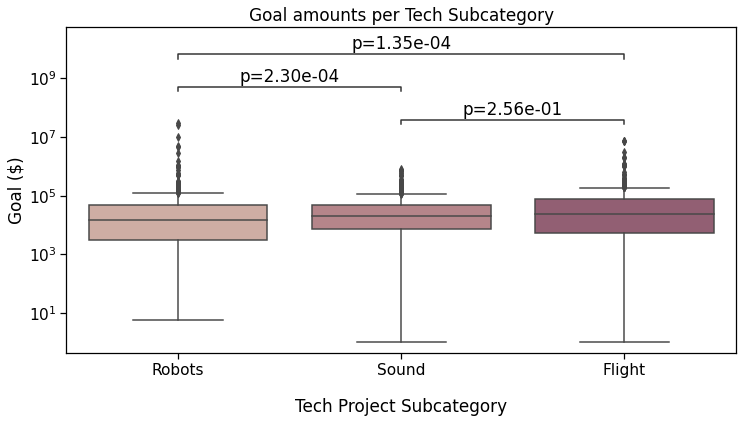

In [38]:
# Putting the parameters in a dictionary avoids code duplication
# since we use the same for `sns.boxplot` and `Annotator` calls
plotting_parameters = {
    'data':    rfs,
    'x':       'Subcategory',
    'y':       'Goal',
    'palette': subcat_palette[1:]
}

box_pairs = [('Robots', 'Flight'),
             ('Flight', 'Sound'),
             ('Robots', 'Sound')]

with sns.plotting_context('notebook', font_scale = 1.4):
    # Create new plot
    ax = get_log_ax()

    # Plot with seaborn
    sns.boxplot(**plotting_parameters)

    # Add annotations
    annotator = Annotator(ax, box_pairs, **plotting_parameters)
    annotator.set_custom_annotations([f"p={p:.2e}" for p in pvalues])
    annotator.annotate()

    # Label and show
    label_plot_for_subcat(ax)
    plt.savefig("./plot1A.png", bbox_inches='tight')
    plt.show()


### B - Let's automatically format these pvalues for prettier result

We will use `set_pvalues` instead of `set_custom_annotations` to benefit from formatting options

#### With the star notation (default)

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Sound v.s. Flight: Custom statistical test, P_val:2.557e-01
Robots v.s. Sound: Custom statistical test, P_val:2.299e-04
Robots v.s. Flight: Custom statistical test, P_val:1.349e-04


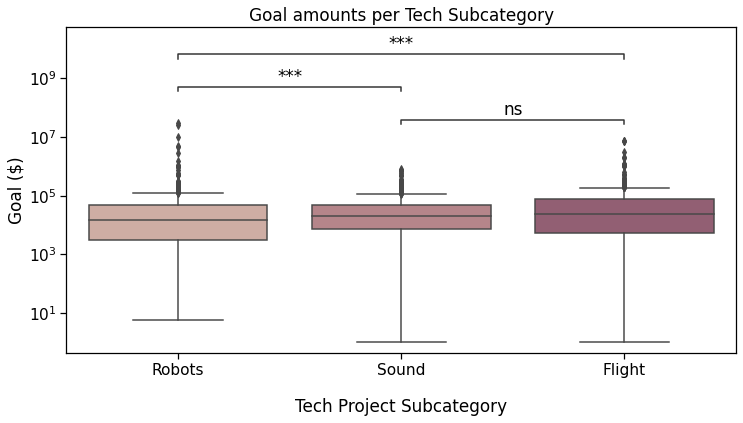

In [18]:
with sns.plotting_context("notebook", font_scale = 1.4):
    # Create new plot
    ax = get_log_ax()

    # Plot with seaborn
    sns.boxplot(ax=ax, **plotting_parameters)

    # Add annotations
    annotator = Annotator(ax, box_pairs, **plotting_parameters)
    annotator.set_pvalues(pvalues)
    annotator.annotate()

    # Label and show
    label_plot_for_subcat(ax)
    plt.show()

#### With a simple format to display significance

In this case, we will configure `text_format` to `simple` to show a summary of pvalues.

Sound v.s. Flight: Custom statistical test, P_val:2.557e-01
Robots v.s. Sound: Custom statistical test, P_val:2.299e-04
Robots v.s. Flight: Custom statistical test, P_val:1.349e-04


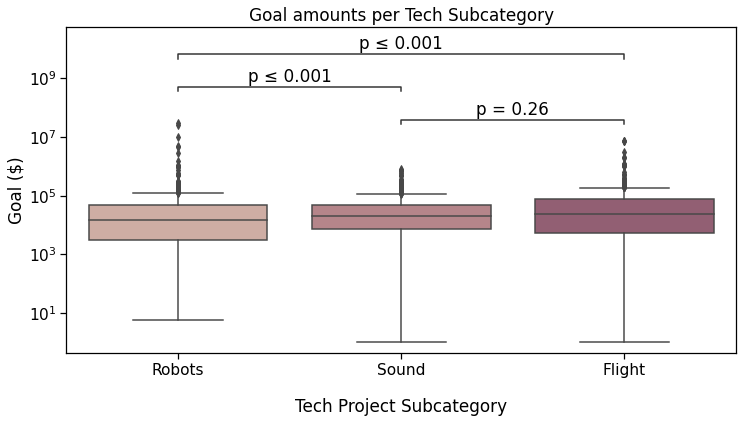

In [19]:
with sns.plotting_context("notebook", font_scale = 1.4):
    # Create new plot
    ax = get_log_ax()

    # Plot with seaborn
    sns.boxplot(ax=ax, **plotting_parameters)

    # Add annotations
    annotator = Annotator(ax, box_pairs, **plotting_parameters)
    annotator.configure(text_format="simple")
    annotator.set_pvalues(pvalues).annotate()

    # Label and show
    label_plot_for_subcat(ax)
    plt.show()

We can also provide a `test_short_name` parameter to be displayed right before the pvalue.

I'll also show how to reduce the code needed a bit more by reusing the annotator instance,
since we are not changing the data and box_pairs. This will also remember our `text_format` option configured.

Sound v.s. Flight: Custom statistical test, P_val:2.557e-01
Robots v.s. Sound: Custom statistical test, P_val:2.299e-04
Robots v.s. Flight: Custom statistical test, P_val:1.349e-04


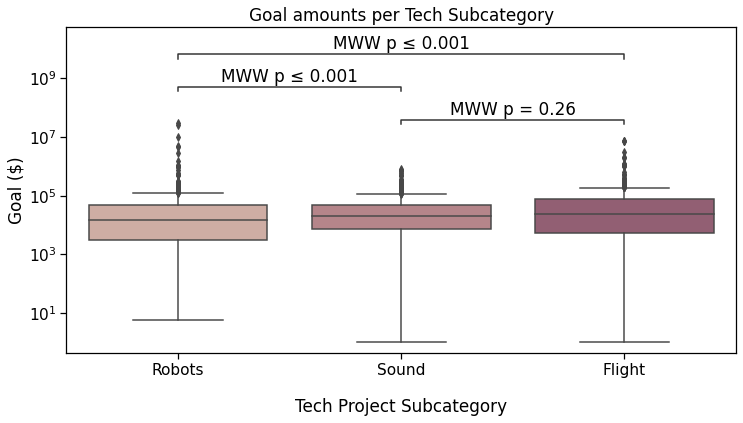

In [20]:
with sns.plotting_context("notebook", font_scale = 1.4):
    # Create new plot
    ax = get_log_ax()

    # Plot with seaborn
    sns.boxplot(ax=ax, **plotting_parameters)

    # Add annotations
    annotator.new_plot(ax, **plotting_parameters)  # Same box_pairs and data, we can keep the annotator
    annotator.configure(test_short_name="MWW")     # text_format is still simple
    annotator.set_pvalues_and_annotate(pvalues)    # in one function call

    # Label and show
    label_plot_for_subcat(ax)
    plt.show()

#### Tweak the layout

I would like to see more space between the annotations and the text.

The `annotate` method allows to parameters to do just that

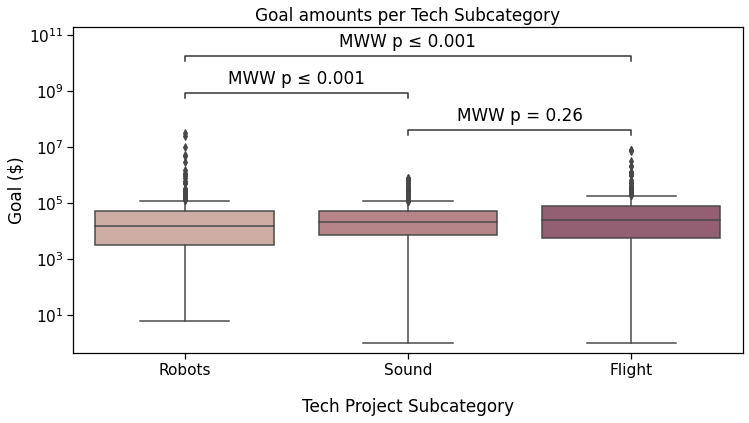

In [21]:
with sns.plotting_context("notebook", font_scale = 1.4):
    # Create new plot
    ax = get_log_ax()

    # Plot with seaborn
    sns.boxplot(ax=ax, **plotting_parameters)

    # Add annotations
    annotator.new_plot(ax, **plotting_parameters)    # Same box_pairs and data, we can keep the annotator
    annotator.configure(text_offset = 5, verbose=0)  # Disabling printed output as it is the same
    annotator.set_pvalues(pvalues)                   # Now, test_short_name is also remembered
    annotator.annotate()

    # Label and show
    label_plot_for_subcat(ax)
    plt.show()

### Use statannotations to apply scipy test

You can use `statannotations` take care of most of the steps required to run the test and annotate the plot.
The available options are

- Mann-Whitney
- t-test (independent and paired)
- Welch's t-test
- Levene test
- Wilcoxon test
- Kruskal-Wallis test

In the next tutorial, I'll cover how to use a test that is not one of those already interfaced in `statannotations`.
If you are curious, you can also take a look at the usage [notebook](https://github.com/trevismd/statannotations/blob/master/usage/example.ipynb) in the project repository.

Sound v.s. Flight: Mann-Whitney-Wilcoxon test two-sided, P_val:2.557e-01 U_stat=1.367e+05
Robots v.s. Sound: Mann-Whitney-Wilcoxon test two-sided, P_val:2.299e-04 U_stat=1.682e+05
Robots v.s. Flight: Mann-Whitney-Wilcoxon test two-sided, P_val:1.349e-04 U_stat=1.046e+05


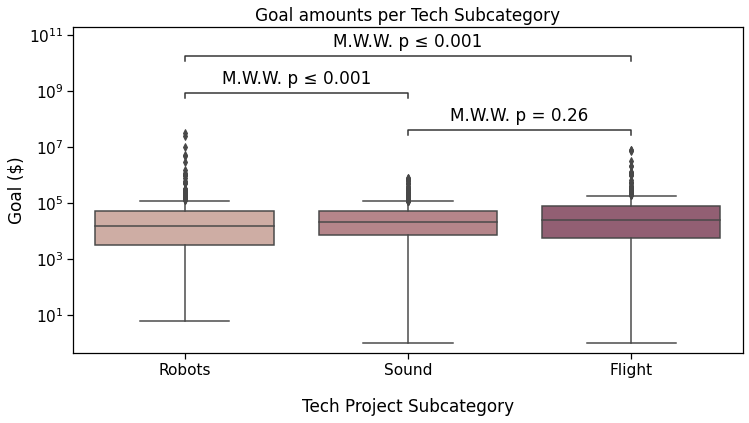

In [22]:
with sns.plotting_context('notebook', font_scale = 1.4):
    # Create new plot
    ax = get_log_ax()

    # Plot with seaborn
    sns.boxplot(ax=ax, **plotting_parameters)

    # Add annotations
    annotator.new_plot(ax, box_pairs=box_pairs, **plotting_parameters)
    annotator.configure(test='Mann-Whitney', verbose=True).apply_and_annotate()

    # Label and show
    label_plot_for_subcat(ax)
    plt.show()

There is also the `"full"` format for annotations

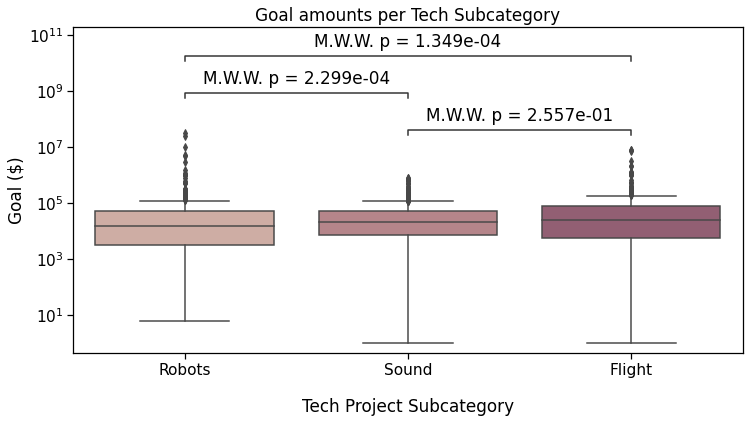

In [23]:
with sns.plotting_context("notebook", font_scale = 1.4):
    # Create new plot
    ax = get_log_ax()

    # Plot with seaborn
    sns.boxplot(ax=ax, **plotting_parameters)

    # Add annotations
    annotator.new_plot(ax, **plotting_parameters)
    annotator.configure(text_format="full", verbose=False).apply_and_annotate()

    # Label and show
    label_plot_for_subcat(ax)
    plt.show()

###### And that plot by `State` ?

![plot2](./plot2.png)

Say we're interested in comparing 'Successful', 'Failed', 'Cancelled' and 'Live' states

In [24]:
values = rfs.loc[(rfs.State == "Successful"), "Goal"].values
describe_array(values, "Successful", 18)
print(normaltest(values), "\n")

log_values = np.log(rfs.loc[(rfs.State == "Successful"), "Goal"].values)
describe_array(values, "Log(Successful)", 18)
print(normaltest(log_values))

"Successful"      Number of projects: 576	Min: 1.00	Max: 8.00e+05	Avg: 31438.18	Median: 1.38e+04
NormaltestResult(statistic=756.6903519347284, pvalue=4.8615843204626055e-165) 

"Log(Successful)" Number of projects: 576	Min: 1.00	Max: 8.00e+05	Avg: 31438.18	Median: 1.38e+04
NormaltestResult(statistic=56.79986477039819, pvalue=4.635174393791566e-13)


We will need to define the new box_pairs to compare, then apply the same method to configure, get test results and annotate the plot.

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Successful v.s. Failed: Mann-Whitney-Wilcoxon test two-sided, P_val:2.813e-08 U_stat=1.962e+05
Failed v.s. Live: Mann-Whitney-Wilcoxon test two-sided, P_val:2.511e-01 U_stat=9.932e+03
Successful v.s. Live: Mann-Whitney-Wilcoxon test two-sided, P_val:9.215e-01 U_stat=5.971e+03
Live v.s. Canceled: Mann-Whitney-Wilcoxon test two-sided, P_val:6.641e-03 U_stat=1.460e+03
Failed v.s. Canceled: Mann-Whitney-Wilcoxon test two-sided, P_val:1.423e-05 U_stat=7.239e+04
Successful v.s. Canceled: Mann-Whitney-Wilcoxon test two-sided, P_val:4.054e-16 U_stat=3.910e+04


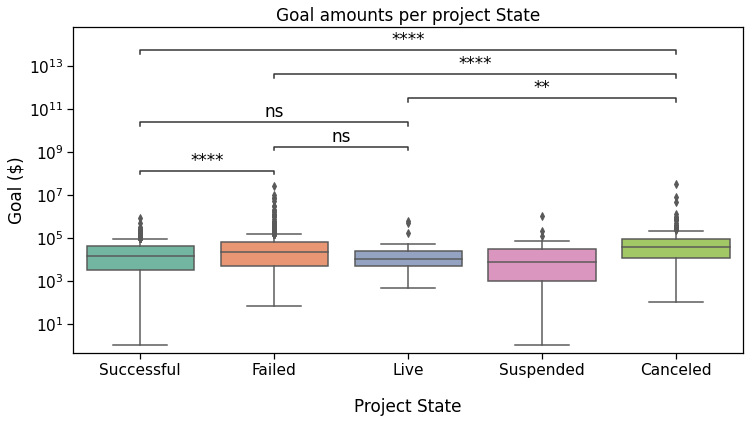

In [41]:
box_pairs = [
    ("Successful", "Failed"),
    ("Successful", "Live"),
    ("Failed", "Live"),
    ("Canceled", "Successful"),
    ("Canceled", "Failed"),
    ("Canceled", "Live"),
]

state_plot_params = {
    'data': rfs,
    'x': 'State',
    'y': 'Goal',
    'order': states_order,
    'palette': state_palette
}

with sns.plotting_context('notebook', font_scale = 1.4):
    # Create new plot
    ax = get_log_ax()

    # Plot with seaborn
    sns.boxplot(ax=ax, **state_plot_params)

    # Add annotations
    annotator = Annotator(ax, box_pairs, **state_plot_params)
    annotator.configure(test='Mann-Whitney').apply_and_annotate()

    # Label and show
    label_plot_for_state(ax)
    plt.savefig("./plot2C.png", bbox_inches="tight")
    plt.show()

Now, that's a pretty plot !

If you are worried about multiple testing and correction methods, read on !

But first, let's see what happends with two levels of categorization, box plots with hue.

### Boxplots with hue

We are also going to work on these two plots of the same data

#### PLOT 3

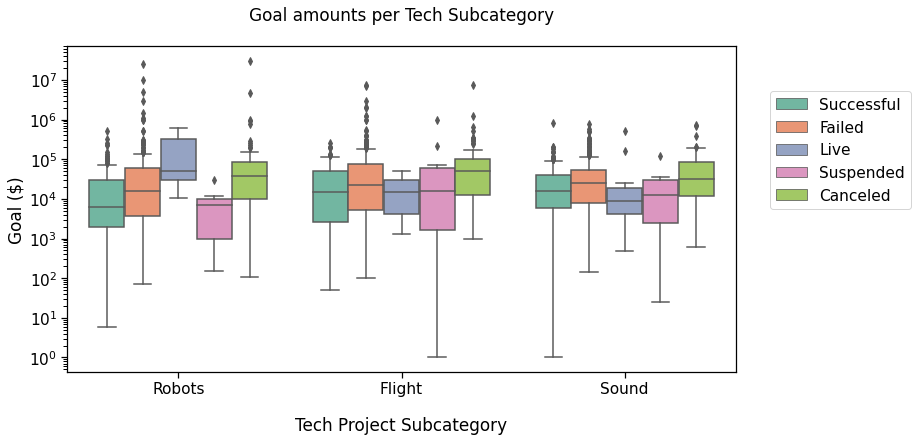

In [26]:
with sns.plotting_context('notebook', font_scale = 1.4):
    # Create new plot
    ax = get_log_ax()

    # Plot with seaborn
    ax = sns.boxplot(ax=ax,
                     data=rfs,
                     x='Subcategory', y='Goal',
                     order=subcat_order,
                     hue="State",
                     hue_order=states_order,
                     palette=state_palette)

    # Label and show
    add_legend(ax)
    label_plot_for_subcat(ax)
    plt.show()

I'd like to compare "Successful" and "Failed" and "Live" states in the 3 subcategories.
Box pairs must then contain the information
about the subcategory and the state, and are defined as below

In [27]:
box_pairs = [
    [('Robots', 'Successful'), ('Robots', 'Failed')],
    [('Flight', 'Successful'), ('Flight', 'Failed')],
    [('Sound', 'Successful'), ('Sound', 'Failed')],

    [('Robots', 'Successful'), ('Robots', 'Live')],
    [('Flight', 'Successful'), ('Flight', 'Live')],
    [('Sound', 'Successful'), ('Sound', 'Live')],

    [('Robots', 'Failed'), ('Robots', 'Live')],
    [('Flight', 'Failed'), ('Flight', 'Live')],
    [('Sound', 'Failed'), ('Sound', 'Live')],
]

again, putting plot parameters in a dictionnary so we can use it twice, then using the Annotator

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Sound_Failed v.s. Sound_Live: Mann-Whitney-Wilcoxon test two-sided, P_val:5.311e-02 U_stat=2.534e+03
Robots_Successful v.s. Robots_Failed: Mann-Whitney-Wilcoxon test two-sided, P_val:1.435e-04 U_stat=2.447e+04
Robots_Failed v.s. Robots_Live: Mann-Whitney-Wilcoxon test two-sided, P_val:2.393e-01 U_stat=2.445e+02
Flight_Successful v.s. Flight_Failed: Mann-Whitney-Wilcoxon test two-sided, P_val:4.658e-02 U_stat=8.990e+03
Flight_Failed v.s. Flight_Live: Mann-Whitney-Wilcoxon test two-sided, P_val:4.185e-01 U_stat=6.875e+02
Sound_Successful v.s. Sound_Failed: Mann-Whitney-Wilcoxon test two-sided, P_val:1.222e-03 U_stat=3.191e+04
Robots_Successful v.s. Robots_Live: Mann-Whitney-Wilcoxon test two-sided, P_val:8.216e-02 U_stat=1.405e+02
Flight_Successful v.s. Flight_Live: Mann-Whitney-Wilcoxon test two-sided, P_val:

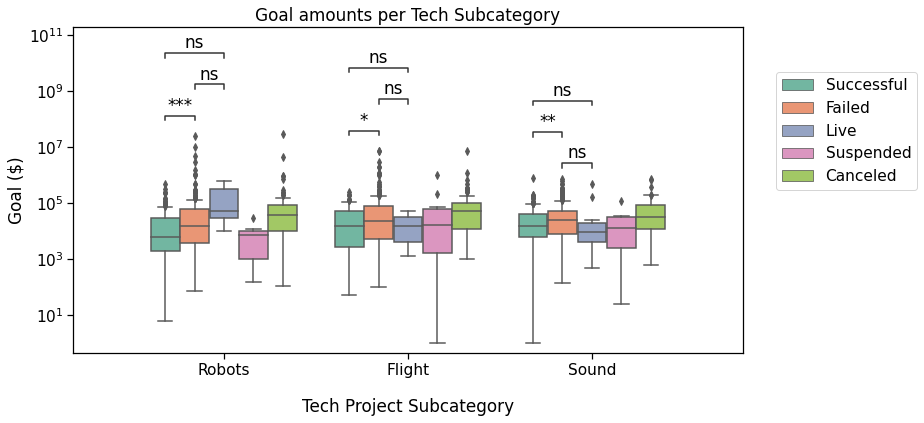

In [28]:
hue_plot_params = {
    'data': rfs,
    'x': 'Subcategory',
    'y': 'Goal',
    "order": subcat_order,
    "hue": "State",
    "hue_order": states_order,
    "palette": state_palette
}

with sns.plotting_context("notebook", font_scale = 1.4):
    # Create new plot
    ax = get_log_ax()

    # Plot with seaborn
    ax = sns.boxplot(ax=ax, **hue_plot_params)

    # Add annotations
    annotator = Annotator(ax, box_pairs, **hue_plot_params)
    annotator.configure(test="Mann-Whitney").apply_and_annotate()

    # Label and show
    add_legend(ax)
    label_plot_for_subcat(ax)
    plt.show()

#### PLOT 4
To compare the states, across categories, let's plot it differently

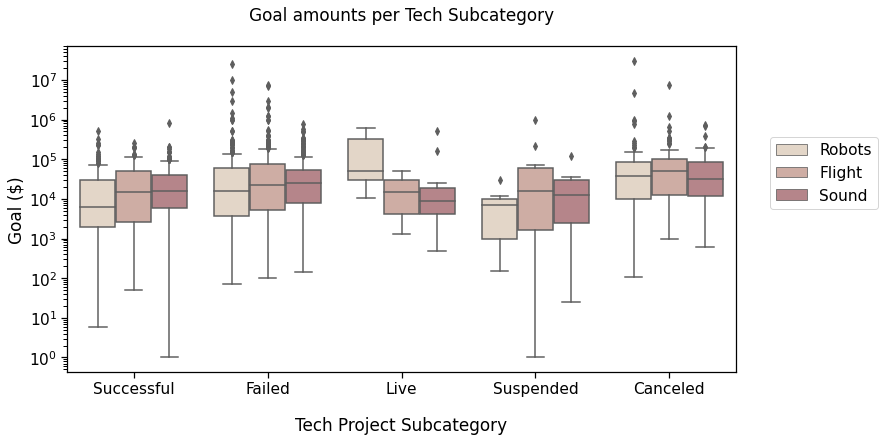

In [29]:
# Switching hue and x
hue_plot_params = {
    'data':      rfs,
    'x':         'State',
    'y':         'Goal',
    "order":     states_order,
    "hue":       "Subcategory",
    "hue_order": subcat_order,
    "palette":   subcat_palette
}

with sns.plotting_context("notebook", font_scale = 1.4):
    # Create new plot
    ax = get_log_ax()

    # Plot with seaborn
    ax = sns.boxplot(ax=ax, **hue_plot_params)

    # Label and show
    add_legend(ax)
    label_plot_for_subcat(ax)
    plt.show()

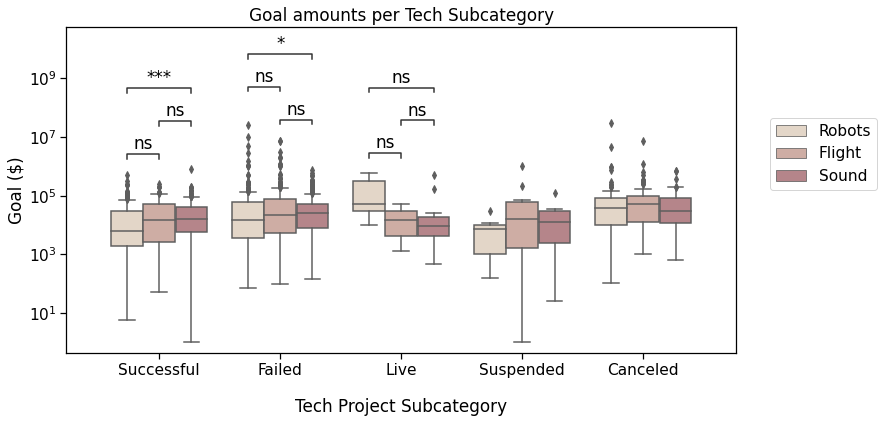

In [30]:
box_pairs =(
    [('Successful', 'Robots'), ('Successful', 'Flight')],
    [('Successful', 'Flight'), ('Successful', 'Sound')],
    [('Successful', 'Robots'), ('Successful', 'Sound')],

    [('Failed', 'Robots'), ('Failed', 'Flight')],
    [('Failed', 'Flight'), ('Failed', 'Sound')],
    [('Failed', 'Robots'), ('Failed', 'Sound')],

    [('Live', 'Robots'), ('Live', 'Flight')],
    [('Live', 'Flight'), ('Live', 'Sound')],
    [('Live', 'Robots'), ('Live', 'Sound')],
)

with sns.plotting_context("notebook", font_scale = 1.4):
    # Create new plot
    ax = get_log_ax()

    # Plot with seaborn
    ax = sns.boxplot(ax=ax, **hue_plot_params)

    # Add annotations
    annotator = Annotator(ax, box_pairs, **hue_plot_params)
    annotator.configure(test="Mann-Whitney", verbose=False)
    _, results = annotator.apply_and_annotate()

    # Label and show
    add_legend(ax)
    label_plot_for_subcat(ax)
    plt.show()

Now again, that is a lot of tests. If one would like to apply a multiple testing correction method, it is possible.

#### Correcting for multiple testing (introduction)
In this section, I will quickly demonstrate how to use one of the readily available interfaces. More advanced uses will be described in the following tutorial.

Basically, you can use the `comparisons_correction` parameter for the `.configure` method, for one of the following correction methods (as implemented by `statsmodels`)
- Bonferroni ("bonf")
- Benjamini-Hochberg ("BH")
- Holm-Bonferroni ("HB")
- Benjamini-Yekutieli ("BY")

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Failed_Flight v.s. Failed_Sound: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:1.000e+00 U_stat=3.803e+04
Live_Robots v.s. Live_Flight: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:1.000e+00 U_stat=9.500e+00
Live_Flight v.s. Live_Sound: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:1.000e+00 U_stat=2.900e+01
Successful_Robots v.s. Successful_Flight: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:8.862e-01 U_stat=7.500e+03
Successful_Flight v.s. Successful_Sound: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:1.000e+00 U_stat=1.013e+04
Failed_Robots v.s. Failed_Flight: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:8.298e-01 U_stat=3.441e+04
Live_Robots v.s. Live_

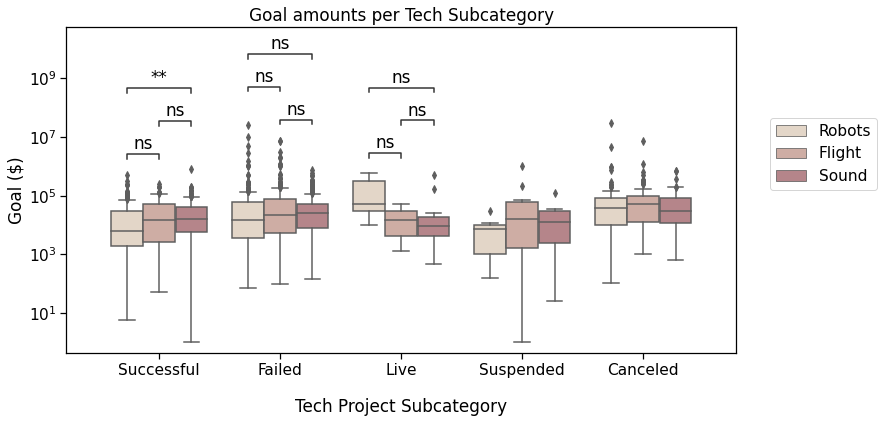

In [31]:
with sns.plotting_context("notebook", font_scale = 1.4):
    # Create new plot
    ax = get_log_ax()

    # Plot with seaborn
    ax = sns.boxplot(ax=ax, **hue_plot_params)

    # Add annotations
    annotator = Annotator(ax, box_pairs, **hue_plot_params)
    annotator.configure(test="Mann-Whitney", comparisons_correction="bonferroni")
    _, corrected_results = annotator.apply_and_annotate()

    # Label and show
    add_legend(ax)
    label_plot_for_subcat(ax)
    plt.show()

Which didn't change the conclusion in this case, but as you can see, the pvalues were corrected

In [32]:
for result, corrected_result in zip(results, corrected_results):
    print(f"{result.pvalue:.2e} => {corrected_result.pvalue:.2e}")

8.04e-01 => 1.00e+00
2.85e-01 => 1.00e+00
9.58e-01 => 1.00e+00
9.85e-02 => 8.86e-01
7.23e-01 => 1.00e+00
9.22e-02 => 8.30e-01
1.15e-01 => 1.00e+00
4.19e-02 => 3.77e-01
1.67e-04 => 1.50e-03


So the difference in goal amounts for `Failed` `Robots` and `Sound` projects went from about `0.04` to about `0.4` (the one before last in previous list), and is no longer considered statistically significant with the default alpha of `0.05`.

## Bonus
Other types of plots are supported. Here is the same plot with `stripplot`, and other tweaked parameters

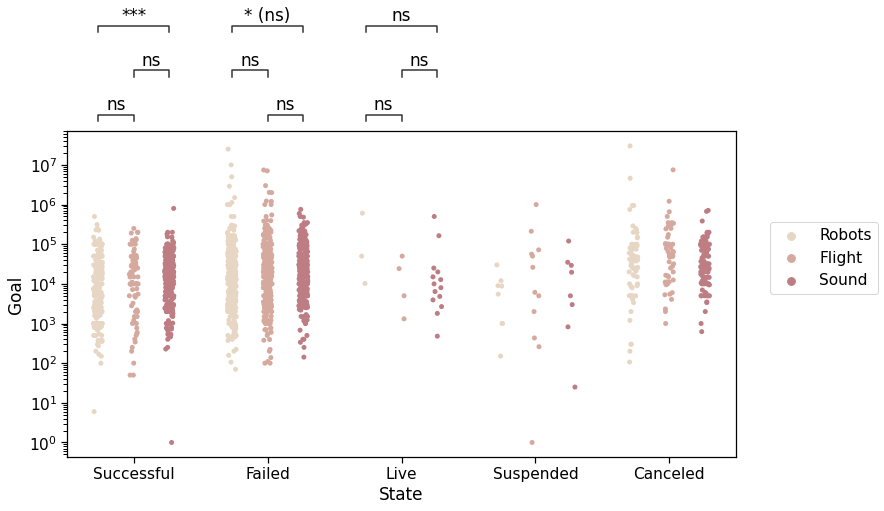

In [33]:
hue_plot_params = {**hue_plot_params, 'dodge': True}

with sns.plotting_context("notebook", font_scale = 1.4):
    # Create new plot
    ax = get_log_ax()

    # Plot with seaborn
    ax = sns.stripplot(ax=ax, **hue_plot_params)

    # Add annotations
    annotator = Annotator(ax, box_pairs, plot='stripplot', **hue_plot_params)
    annotator.configure(test="Mann-Whitney", comparisons_correction="BH",
                        verbose=False, loc="outside")
    _, corrected_results = annotator.apply_and_annotate()

    # Label and show
    add_legend(ax)
    plt.show()